# 다중공선성
- 독립변수 중 일부가 다른 독립변수의 조합으로 표현할 수 있는 상황
- 데이터가 서로 상관관계가 강하게 발생하는 상황


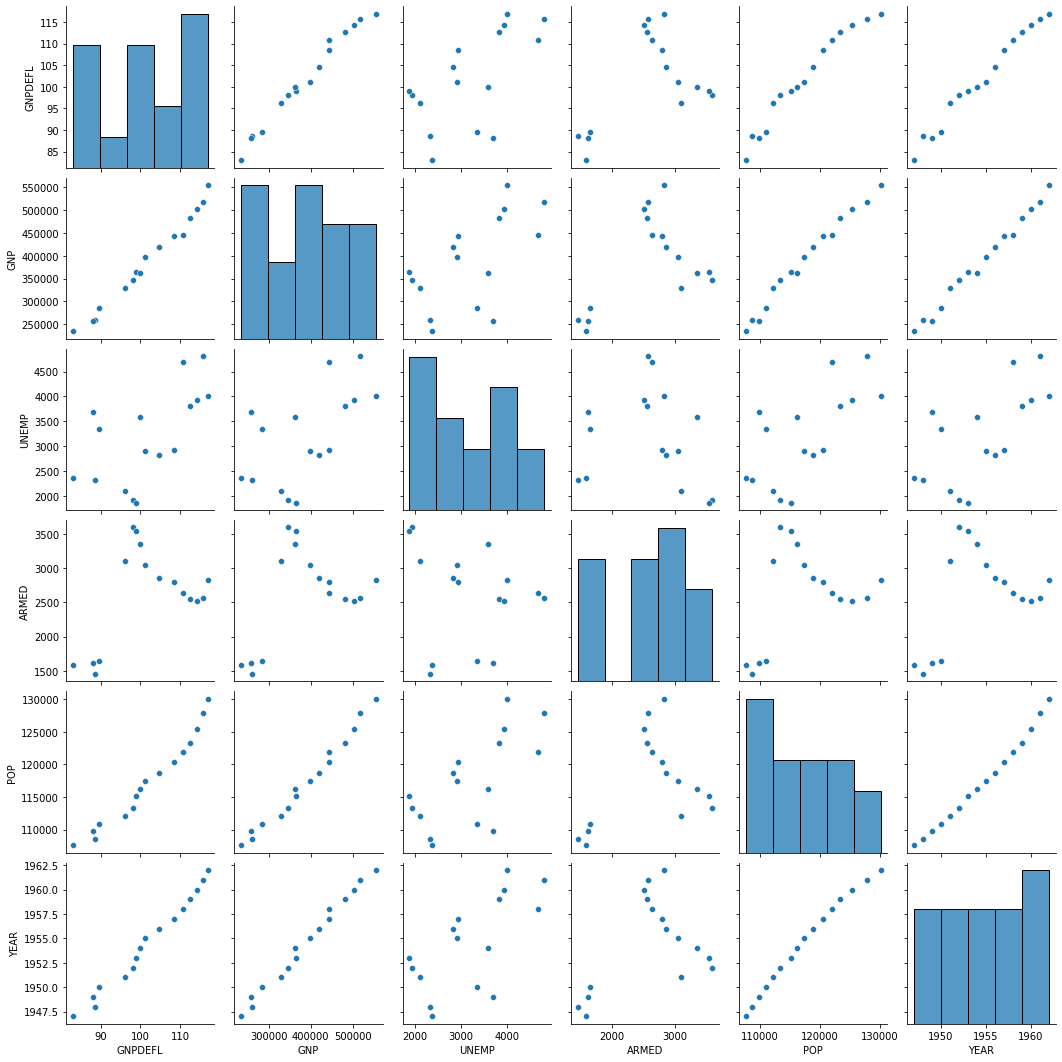

In [2]:
from statsmodels.datasets.longley import load_pandas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dfX = load_pandas().exog
dfy = load_pandas().endog
df = pd.concat([dfX,dfy], axis=1) #가로로 데이터 합체

sns.pairplot(dfX)
plt.show()

In [3]:
dfX.corr()

,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
GNPDEFL,1.000000,0.991589,0.620633,0.464744,0.979163,0.991149
GNP,0.991589,1.000000,0.604261,0.446437,0.991090,0.995273
UNEMP,0.620633,0.604261,1.000000,-0.177421,0.686552,0.668257
ARMED,0.464744,0.446437,-0.177421,1.000000,0.364416,0.417245
POP,0.979163,0.991090,0.686552,0.364416,1.000000,0.993953
YEAR,0.991149,0.995273,0.668257,0.417245,0.993953,1.000000


In [11]:
import statsmodels.api as sm

#과적화 발생
model = sm.OLS.from_formula('TOTEMP ~ GNPDEFL + GNP + UNEMP + ARMED + POP + YEAR', data = df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     330.3
Date:                Sat, 12 Mar 2022   Prob (F-statistic):           4.98e-10
Time:                        12:47:32   Log-Likelihood:                -109.62
No. Observations:                  16   AIC:                             233.2
Df Residuals:                       9   BIC:                             238.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.482e+06    8.9e+05     -3.911      0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


## 과대적합을 줄이기 위한 3가지 방법
- 의존적인, 다른 변수에 영향을 받는 변수를 삭제하는 방법
- PCA(주성분 분석)를 이용한 의존적인 성분을 삭제
- 정규화를 해서 값들을 일정 범위로 만듬( x - x_min / x_max - x_min)

In [26]:
#어떻게 하면 다른 변수에 영향을 받는지를 알 수 있을까?
#VIF = 독립변수를 다른 독립변수로 선형회귀를 해서, 그 정도를 측정

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['coulmns'] = dfX.columns   
vif['vif count'] = [variance_inflation_factor(dfX.values,i) for i in range(dfX.shape[1]) ]

vif

,coulmns,vif count
0,GNPDEFL,12425.514335
1,GNP,10290.435437
2,UNEMP,136.224354
3,ARMED,39.983386
4,POP,101193.161993
5,YEAR,84709.950443


In [29]:
#과적화 발생
model = sm.OLS.from_formula('TOTEMP ~ scale(GNP) + scale(UNEMP) + scale(ARMED)', data = df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     264.4
Date:                Sat, 12 Mar 2022   Prob (F-statistic):           3.19e-11
Time:                        13:06:15   Log-Likelihood:                -119.16
No. Observations:                  16   AIC:                             246.3
Df Residuals:                      12   BIC:                             249.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6.532e+04    119.824    545.106   

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


## 정규화 선형회귀 관련
- Ridge 회귀모형 : 가중치들의 제곱합을 최소화하는 제약(제약을 아에 안주면, 선형회귀와 같아진다) 
- Lasso 회귀모형 : 가중치의 절대값의 합을 최소화하는 제약 
- Elastic net 회귀모형 : 릿지와 라쏘의 제약을 둘다 가지고 있음
- 제약의 정도 : alpha

In [47]:
import numpy as np

def nonlinear(seed = 0):
    np.random.seed(seed)
    n = 100
    X = np.sort(np.random.rand(n))
    y = np.sin(2 * np.pi * X) + np.random.randn(100) * 0.1
    X = X[:, np.newaxis]
    return (X,y)

X, y = nonlinear()

#다중 회귀 분석의 차수를 입력해주는 부분 만들기
# 'y ~ I(x**1) + I(x**2) + I(x**3) + I(x**4)+ I(x**5) + I(x**6)'
degree = 25
string_reg = 'y ~'
for i in range(degree):
    if i == 0:
        plus = ''
    else:
        plus = ' + '
    string_reg += plus + 'I(x**{})'.format(i+1)
    
#다중 선형회귀
dfx = pd.DataFrame(X, columns=['x'])
dfX = sm.add_constant(dfx)
dfy = pd.DataFrame(y, columns=['y'])
df = pd.concat([dfX, dfy], axis = 1)

model = sm.OLS.from_formula(string_reg, data= df)
result = model.fit()
result.params

Intercept     1.687027e-01
I(x ** 1)    -8.724078e+01
I(x ** 2)     8.660599e+03
I(x ** 3)    -3.258458e+05
I(x ** 4)     6.714041e+06
I(x ** 5)    -8.660790e+07
I(x ** 6)     7.525328e+08
I(x ** 7)    -4.600537e+09
I(x ** 8)     2.028081e+10
I(x ** 9)    -6.504098e+10
I(x ** 10)    1.503420e+11
I(x ** 11)   -2.406284e+11
I(x ** 12)    2.353952e+11
I(x ** 13)   -6.827611e+10
I(x ** 14)   -1.385296e+11
I(x ** 15)    1.497789e+11
I(x ** 16)    4.372369e+10
I(x ** 17)   -1.502687e+11
I(x ** 18)    1.411111e+10
I(x ** 19)    1.328464e+11
I(x ** 20)   -6.658723e+10
I(x ** 21)   -9.279098e+10
I(x ** 22)    1.403226e+11
I(x ** 23)   -8.112298e+10
I(x ** 24)    2.302832e+10
I(x ** 25)   -2.655969e+09
dtype: float64

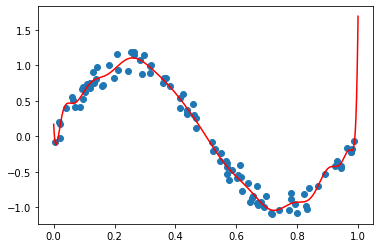

In [48]:
lin_x = np.linspace(0,1,1000)
lin_X = pd.DataFrame(lin_x[:,np.newaxis], columns=['x'])

plt.scatter(X,y)
plt.plot(lin_x, result.predict(lin_X),c= 'r')
plt.show()

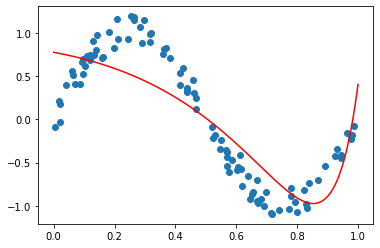

In [51]:
result2 = model.fit_regularized(alpha=0.01, L1_wt = 0) #릿지

plt.scatter(X,y)
plt.plot(lin_x, result2.predict(lin_X),c= 'r')
plt.show()

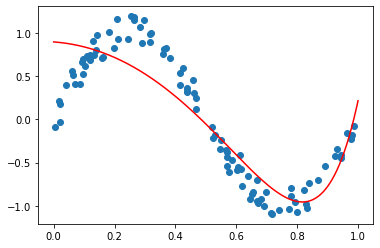

In [52]:
result2 = model.fit_regularized(alpha=0.001, L1_wt = 1) #라쏘

plt.scatter(X,y)
plt.plot(lin_x, result2.predict(lin_X),c= 'r')
plt.show()

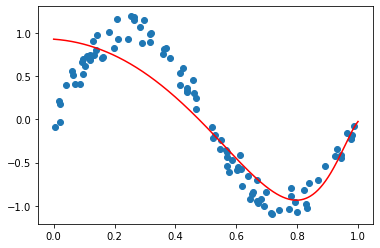

In [60]:
result2 = model.fit_regularized(alpha=0, L1_wt = 0.5) #엘라스틱 넷

plt.scatter(X,y)
plt.plot(lin_x, result2.predict(lin_X),c= 'r')
plt.show()

## 정규화를 쓴 회귀 모형의 장점
- 계수의 변화가 크게 달라지지 않는다

### 릿지와 라쏘의 차이
- 릿지는 가중치의 계수를 한꺼번에 축소시킴
- 라쏘는 일부 가중치의 계수만 0으로 수렴

### 정규화를 할 때 중요한 건 뭘까?
- 적당한 alpha, hyperparameter를 잘 골라야한다.
- 하이퍼파라미터의 범위를 주고 해당 범위안에서 가장 성능이 잘 나오는 파라미터를 선택

In [56]:
#다음주(19일)에 할 것
#sklearn의 정규화 회귀모형
#정규화 최적화를 시각화
#최종적으로는 다중 회귀 차수를 정해보기

NotImplementedError: 